<a href="https://colab.research.google.com/github/sh3986/kaggle/blob/main/%EC%A0%9C%EC%B6%9C_gray_keras_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library

In [ ]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.5f}".format

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

import os
from os import listdir
from os.path import isfile, join
import cv2
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras import optimizers
tf.__version__

'2.8.2'

In [ ]:
# Visualization
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

import skimage.morphology as morp
from skimage.filters import rank

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensoFlow Version:  2.8.2


In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn"

In [ ]:
import os
os.chdir(data_path)

In [ ]:
data = []
labels = []

height = 32
width = 32
channels = 3
num_classes = 43

In [ ]:
# for i in range(num_classes) :
#     path = f'./data/Train/{i}/'
#     Class = os.listdir(path)
#     for a in Class:
#         image = cv2.imread(path + a)
#         image_from_array = Image.fromarray(image, 'RGB')
#         size_image = image_from_array.resize((height, width))
#         data.append(np.array(size_image))
#         labels.append(i)

# data = np.array(data)
# labels = np.array(labels)

# import pickle
# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data.pkl","wb") as f:
#     pickle.dump(data, f)

# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label.pkl","wb") as f:
#     pickle.dump(labels, f)

### 데이터 로드

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data.pkl","rb") as f:
    data = pickle.load(f)

import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label.pkl","rb") as f:
    labels = pickle.load(f)

In [ ]:
print(data.shape)
print(labels.shape)

(26010, 32, 32, 3)
(26010,)


### 전처리

In [ ]:
def Scaler(data_X,method = 'MinMax'):
  X = data_X.copy()
  X = X.astype(np.float64)

  if method == 'Divide255':
    X = X/255.0

  elif method == 'Standard':
    for a in X:
      for i in range(len(['r','g','b'])):
        mean_ = a[:,:,i].mean()
        std_ = a[:,:,i].std()
        a[:,:,i] = (a[:,:,i] - mean_)/std_

  elif method == 'MinMax':
    for a in X:
      for i in range(len(['r','g','b'])):
        max_ = a[:,:,i].max()
        min_ = a[:,:,i].min()
        a[:,:,i] = (a[:,:,i] - min_)/(max_ - min_)

  elif method == 'MinMax255':
    for a in X:
      for i in range(len(['r','g','b'])):
        max_ = a[:,:,i].max()
        min_ = a[:,:,i].min()
        a[:,:,i] = ((a[:,:,i] - min_)/(max_ - min_))*255
    return np.array(X,dtype='uint8')      

  return X

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return np.array(image)

def img_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    image_from_array = Image.fromarray(final, 'RGB')
    size_image = image_from_array.resize((height, width))

    return np.array(size_image)

def preprocessing(data_X):
  data = []
  for img in data_X:
    img = img_contrast(to_grayscale_then_rgb(img))
    data.append(img)
  data = np.array(data)

  return data 

In [ ]:
X = data
y = tf.one_hot(labels, num_classes).numpy()

In [ ]:
X = preprocessing(Scaler(X, 'MinMax255'))

### Augmentation

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

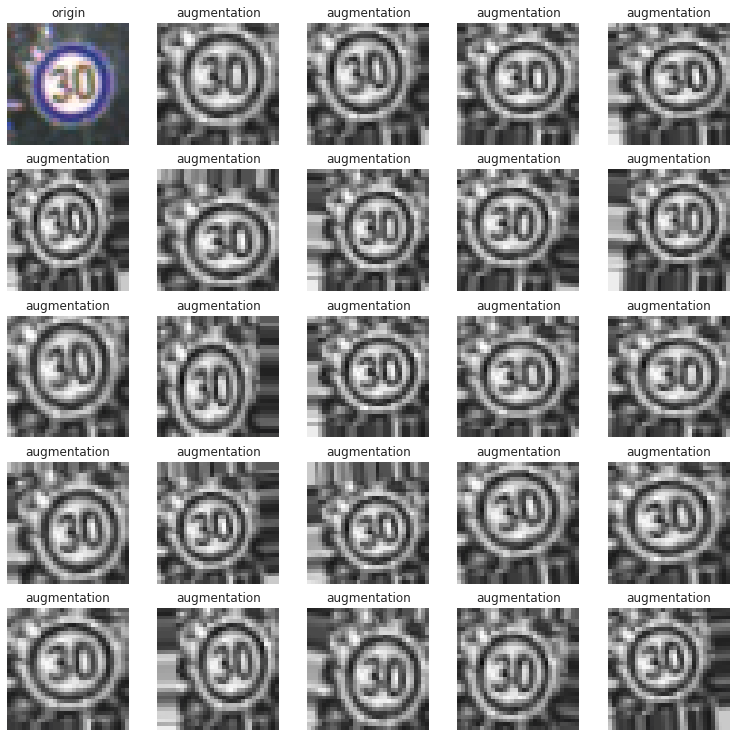

In [ ]:
idx = 1000
origin_img = data[idx]
input_img = X[idx]
input_label = y[idx]
input_img =  np.array([input_img]) 

generator = aug.flow(input_img, batch_size=1)
f, axes = plt.subplots(5, 5, figsize=(13, 13))
ax_list = axes.flat
ax_list[0].imshow(origin_img/255)
ax_list[0].axis('off')
ax_list[0].set_title("origin")

for i, img in enumerate(generator):
    ax_list[i+1].imshow(img[0]/255)
    ax_list[i+1].axis('off')   
    ax_list[i+1].set_title("augmentation")
    if i > 22:
        break

### Train Test Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (18207, 32, 32, 3)
X_valid.shape (7803, 32, 32, 3)
y_train.shape (18207, 43)
y_valid.shape (7803, 43)


In [ ]:
from tensorflow import keras
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(height,width,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
lr = 0.001
epochs = 30
opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model_check = ModelCheckpoint('./workplace/model/final_model_gray.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

In [ ]:
history = model.fit(
    aug.flow(X_train, y_train, batch_size=32), 
    epochs=epochs, 
    validation_data=(X_val, y_val),
    callbacks = [model_check, early, reduce_lr]
)

Epoch 1/30
569/569 [==============================] - 21s 18ms/step - loss: 1.0763 - accuracy: 0.7097 - val_loss: 0.2450 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 2/30
569/569 [==============================] - 10s 17ms/step - loss: 0.2666 - accuracy: 0.9165 - val_loss: 0.1714 - val_accuracy: 0.9473 - lr: 0.0010
Epoch 3/30
569/569 [==============================] - 9s 16ms/step - loss: 0.1498 - accuracy: 0.9550 - val_loss: 0.1735 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 4/30
569/569 [==============================] - 10s 18ms/step - loss: 0.1178 - accuracy: 0.9638 - val_loss: 0.0384 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 5/30
569/569 [==============================] - 12s 20ms/step - loss: 0.0889 - accuracy: 0.9730 - val_loss: 0.0997 - val_accuracy: 0.9651 - lr: 0.0010
Epoch 6/30
569/569 [==============================] - 10s 18ms/step - loss: 0.0800 - accuracy: 0.9739 - val_loss: 0.0444 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 7/30
569/569 [==============================] - 10s 1

### 모델 평가

In [ ]:
from tensorflow import keras 
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
macro_list = []
for train_idxs, test_idxs in cv.split(X, labels):
    X_train, X_test = X[train_idxs], X[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]

    X_test = X_test / 255.0

    valid_datagen = ImageDataGenerator()
    valid_generator = valid_datagen.flow(
        X_test, y_test,
        batch_size = 32,
        shuffle=False
    )

    valid_generator.reset()
    y_pred = model.predict_generator(valid_generator)
    y_pred = tf.argmax(y_pred, axis=1).numpy()

    report = classification_report(np.argmax(y_test, axis=1), y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    f1 = df.loc['macro avg']['f1-score']
    macro_list.append(f1)

In [ ]:
print([round(x, 4) for x in macro_list])
print('f1 avg : ', np.mean(macro_list))

[0.998, 0.9983, 0.9986, 0.9969, 0.9975]
f1 avg :  0.9978478372754495


### 모델 테스트

In [ ]:
# from tensorflow import keras 
# model = keras.models.load_model(model_name)

In [ ]:
# test_data = []
# file_name = []
# path = f'./data/Test/'
# Class = os.listdir(path)
# for a in Class:
#     image = cv2.imread(path + a)
#     image = img_contrast(image)
#     image_from_array = Image.fromarray(image, 'RGB')
#     size_image = image_from_array.resize((height, width))
#     test_data.append(np.array(size_image))
#     file_name.append(a)

# test_data = np.array(test_data)
# file_name = np.array(file_name)

# import pickle 

# with open('./data/test_data_contrast.pkl', 'wb') as f:
#     pickle.dump(test_data, f)

# with open('./data/file_name_contrast.pkl', 'wb') as f:
#     pickle.dump(file_name, f)

In [ ]:
with open('./data/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('./data/file_name.pkl', 'rb') as f:
    file_name = pickle.load(f)

In [ ]:
test_data = preprocessing(Scaler(test_data, 'MinMax255'))
test_data = test_data / 255
test_data.shape

(8670, 32, 32, 3)

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    test_data,
    batch_size = 32,
    shuffle=False
) 

In [ ]:
test_generator.reset()
test_label = model.predict_generator(test_generator)
test_label = tf.argmax(test_label, axis=1).numpy()

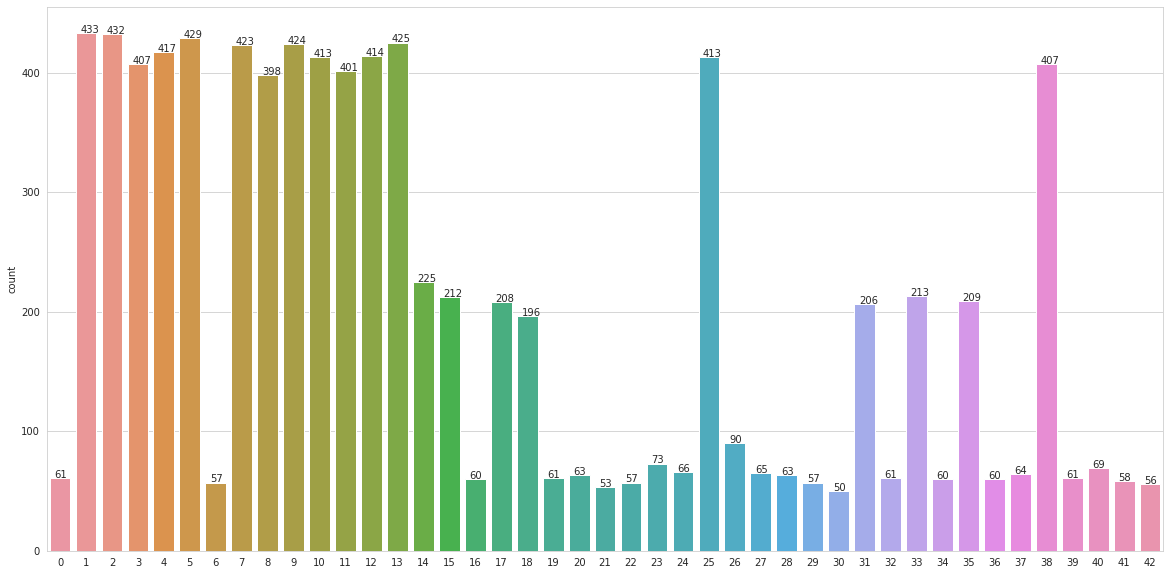

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(test_label)

for p, label in zip(ax.patches, np.bincount(test_label)):
    ax.annotate(label, (p.get_x()+0.175, p.get_height()+0.15))

In [ ]:
csv_data = pd.DataFrame(np.concatenate((file_name.reshape(-1, 1), test_label.reshape(-1,1)), axis=1))
csv_data = csv_data.sort_values(by=[0])
csv_data.head()

,0,1
279,00000.png,16
8119,00001.png,1
3628,00002.png,38
1565,00003.png,33
5360,00004.png,11


In [ ]:
csv_data.to_csv("final_predict_v4_gray.csv", header=False, index=False)
from google.colab import files
files.download("final_predict_v4_gray.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 디버그

In [39]:
img_data = [np.array(x) for x in test_data]
img_df = pd.DataFrame({'img':img_data, 'file_name':file_name, 'label':test_label})
debug_data = img_df.sort_values(by=['file_name'])

def debug_image(debug_data, category, next_file=None):
    filter_data = debug_data[debug_data['label']==category].reset_index()
    if next_file is not None:
        filter_data = filter_data[filter_data['file_name'] > next_file]

    fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        record = filter_data.iloc[i]
        img = record['img']
        file_name = record['file_name']
        ax.imshow(img)
        ax.set_title(file_name, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show() 

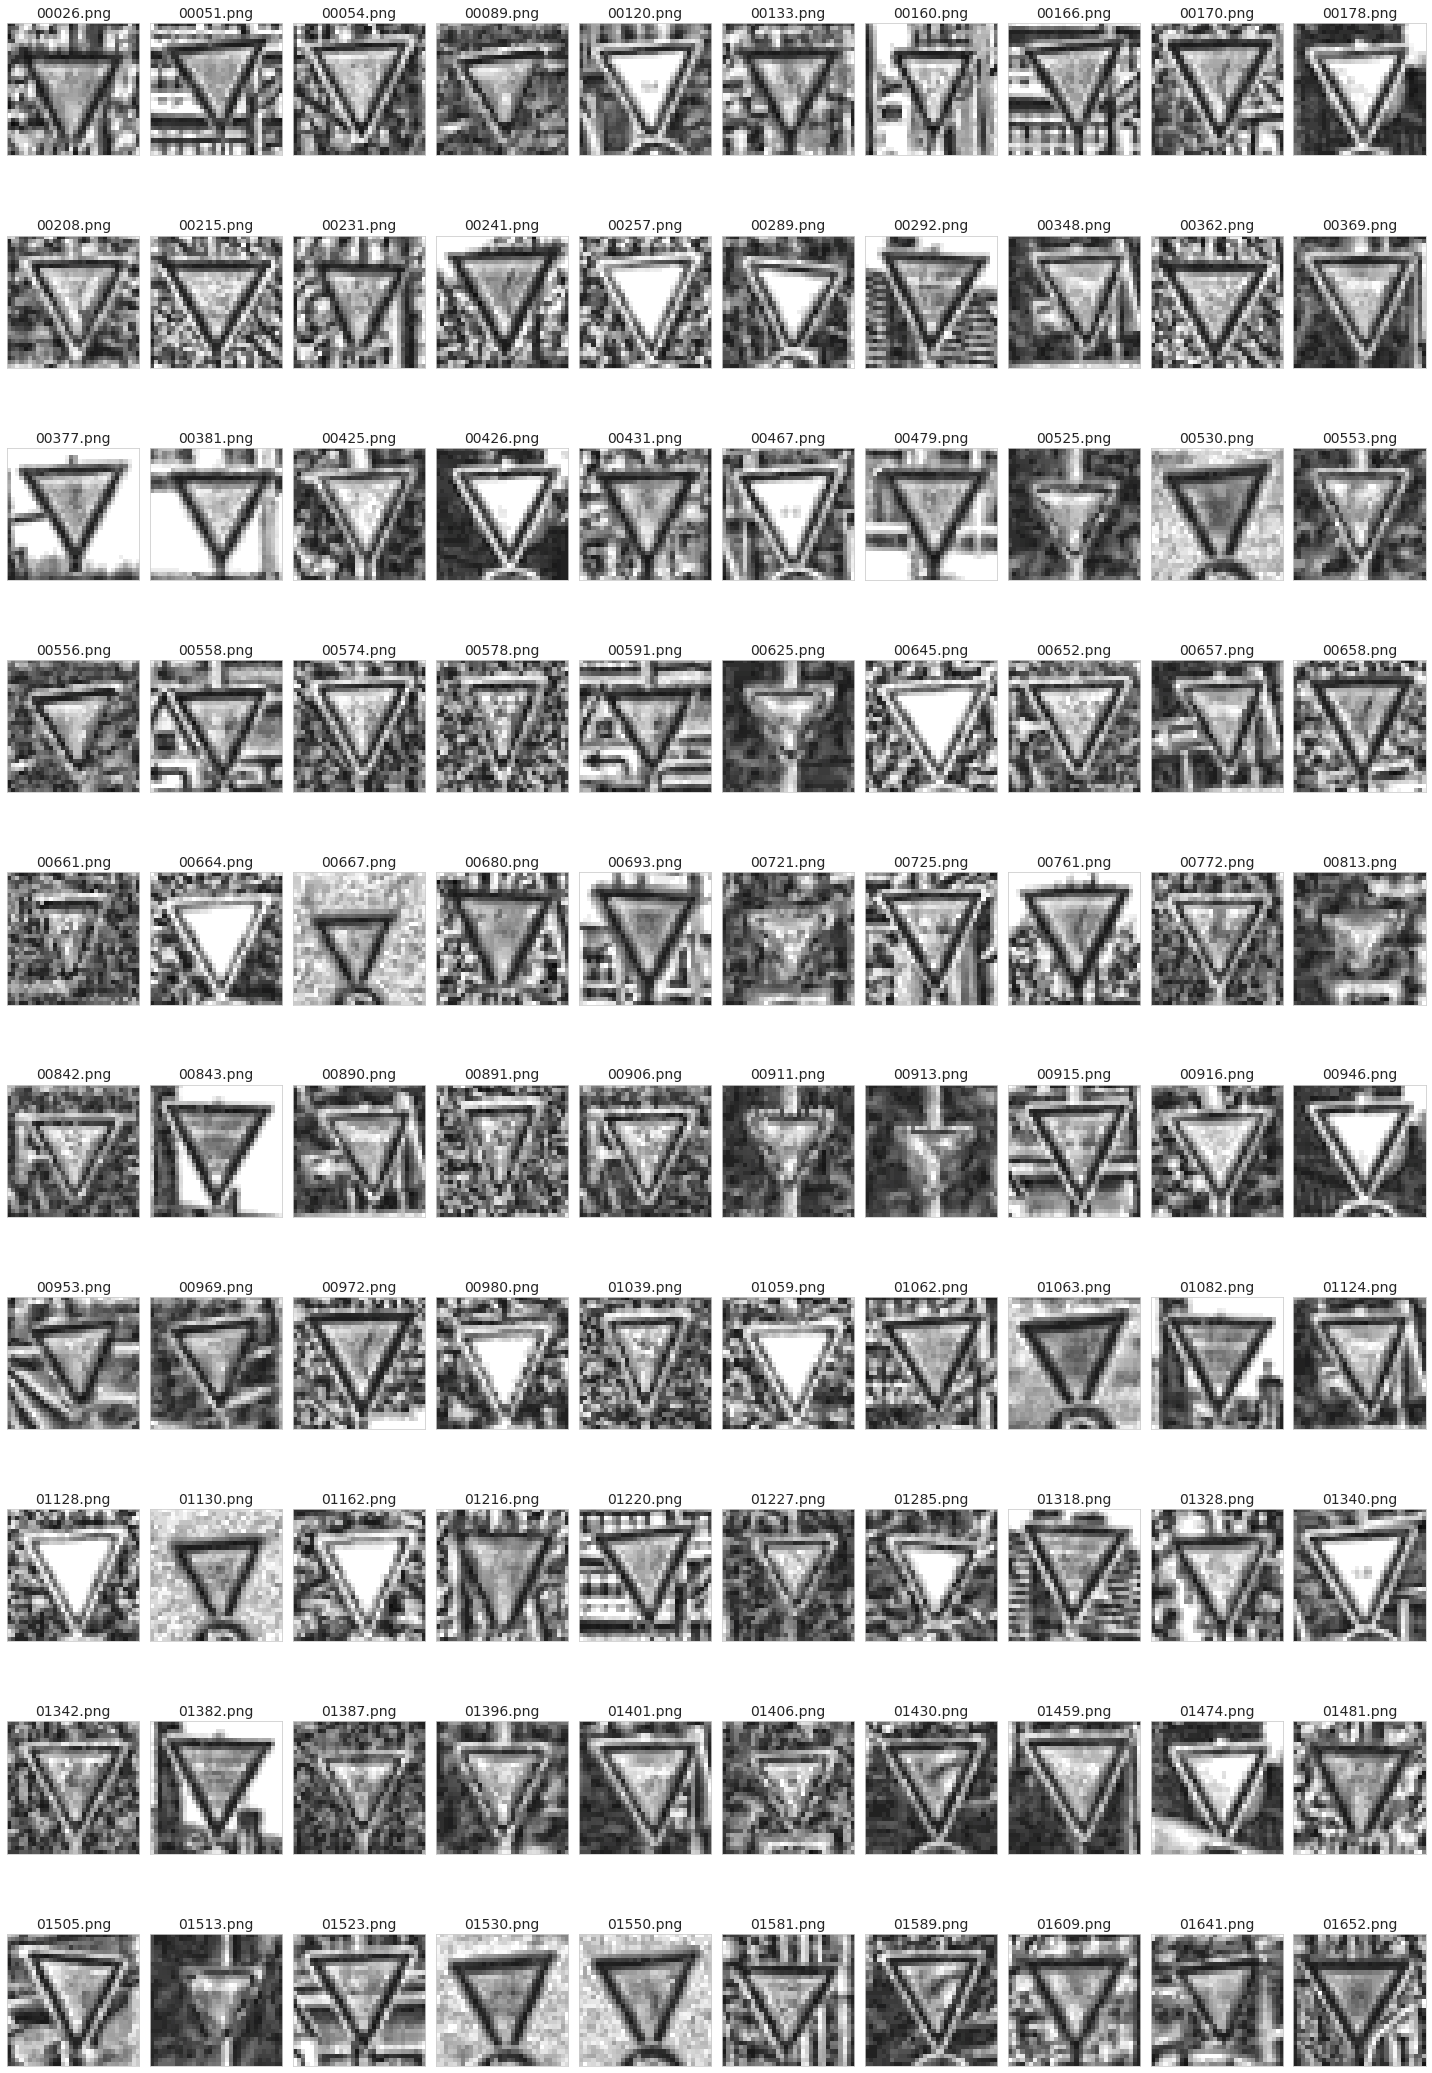

In [40]:
debug_image(debug_data, 13)

### 주석